In [1]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import requests
from bs4 import BeautifulSoup
import itertools
from matplotlib.patches import RegularPolygon
from IPython.display import Markdown, display,Image,HTML
from z3 import *

from math import gcd

Show Solution Fill the empty cells in the grid above with digits such that each row, column, and outlined 3-by-3 box contains the same set of nine unique digits 1 , and such that the nine 9-digit numbers 2 formed by the rows of the grid has the highest-possible GCD over any such grid. Some of the cells have already been filled in. The answer to this puzzle is the 9-digit number formed by the middle row in the completed grid. that is, you’ll be using nine of the ten digits (0-9) in completing this grid ↩

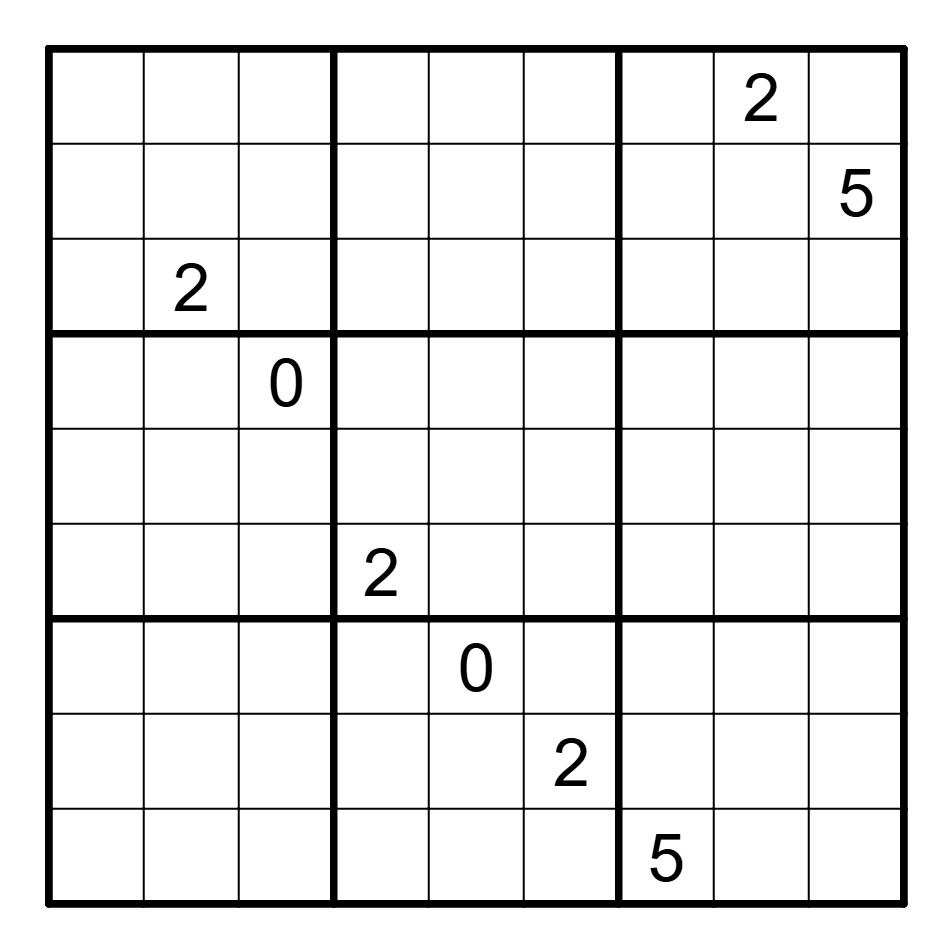

In [2]:
url='https://www.janestreet.com/puzzles/somewhat-square-sudoku-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(x)])
display(Markdown(" ".join(x[15:26])))
display(Image('https://www.janestreet.com/puzzles/20250101_sudoku.png',width=200))

In [3]:
# 50 mins with my numba enhanced backtracking
# less than 0.4 of a sec with z3

# Setup the constraints
fixed = np.array([ [-1, -1, -1, -1, -1, -1, -1,  2, -1],
                   [-1, -1, -1, -1, -1, -1, -1, -1,  5],
                   [-1,  2, -1, -1, -1, -1, -1, -1, -1],
                   [-1, -1,  0, -1, -1, -1, -1, -1, -1],
                   [-1, -1, -1, -1, -1, -1, -1, -1, -1],
                   [-1, -1, -1,  2, -1, -1, -1, -1, -1],
                   [-1, -1, -1, -1,  0, -1, -1, -1, -1],
                   [-1, -1, -1, -1, -1,  2, -1, -1, -1],
                   [-1, -1, -1, -1, -1, -1,  5, -1, -1]])
fixed

array([[-1, -1, -1, -1, -1, -1, -1,  2, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  5],
       [-1,  2, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1,  0, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1,  2, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1,  0, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1,  2, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1,  5, -1, -1]])

In [4]:
def sol_print(solution):
    x= np.ones((3,3))
    groups = np.block([[x*0,x*1,x*2],[x*3,x*4,x*5],[x*6,x*7,x*8]])
    fig,ax = plt.subplots(1,1,figsize=(4,4))
    y = (fixed > -1) + groups*2
    ax = sns.heatmap(y,annot=solution,cbar=False,cmap="tab20",fmt="",linewidths=2,annot_kws={"size":14})
    ax.axis("off")

GCD 12345679.Answer 283,950,617 Took 1.5104 seconds
Unique


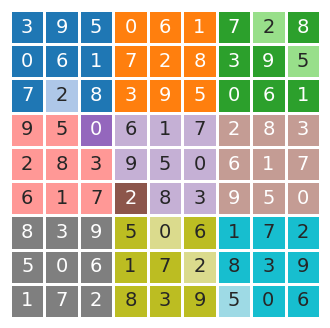

In [7]:
### 9x9 matrix of integer variables

s = Tactic("qffd").solver()

X = np.array(IntVector("x",9*9),dtype=object).reshape((9,9))
Y = np.array(IntVector("y",9))
Z= Int('z')

#s.maximize(Z)
s+= Z == 999999999/9/9
#s += And(Z>=112,Z<=999999999) 
s += [And(e>=1,e<100000000) for e in Y]

# numbers are between 1 & 9
s += [And(e >= 0  ,e <=9) for _,e in np.ndenumerate(X)]

# Fixed
s += [e == int(fixed[i,j]) for (i,j),e in np.ndenumerate(X) if fixed[i,j] !=-1]

# rows & columns distinct
x= np.ones((3,3))
groups = np.block([[x*0,x*1,x*2],[x*3,x*4,x*5],[x*6,x*7,x*8]])

for n in range(9):
    for x in range(10):
        s += PbLe([(e==x,1) for e in X[:,n]],1)
        s += PbLe([(e==x,1) for e in X[n,:]],1) 
        s += PbLe([(e==x,1) for (i,j),e in np.ndenumerate(X) if groups[i,j] ==n],1)

for x in range(10):
    s += Or(PbEq([(e==x,1) for (i,j),e in np.ndenumerate(X) ],9),PbEq([(e==x,1) for (i,j),e in np.ndenumerate(X) ],0))

for n in range(9):
   s+=Sum([e*10**x for x,e in enumerate(X[n,:][::-1])]) == Y[n]*Z


start=time.time()
if s.check() == sat:
    m = s.model()
    evalu = np.vectorize(lambda x:m.evaluate(x).as_long())
    r = evalu(X)

    test_gcd = gcd(*[sum([e*10**x for x,e in enumerate(r[i,:][::-1])]) for i in range(9)])
    print("GCD {}.Answer {:,.0f} Took {:.4f} seconds".format(test_gcd,sum([e*10**x for x,e in enumerate(r[4,:][::-1])]),time.time()-start))
    sol_print(np.array(r))     
    s+= Or([e != int(r[i,j]) for (i,j),e in np.ndenumerate(X)])
    if s.check() == sat:
        print("Not Unique")
    else:
        print("Unique")
else:
    print("Failed in {} seconds".format(time.time()-start))
    